In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

## Day 25 Lecture 2 Assignment

In this assignment, we will extend a previous binary model to a multinomial case with three classes. We will use the FIFA soccer ratings dataset loaded below and analyze the model generated for this dataset.

In [2]:
import numpy as np
import pandas as pd

import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
)

import matplotlib.pyplot as plt

%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
def remove_correlated_features(dataset, threshold):
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (
                corr_matrix.columns[j] not in col_corr
            ):
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
                if colname in dataset.columns:
                    print(f"Deleted {colname} from dataset.")
                    del dataset[colname]

    return dataset

<IPython.core.display.Javascript object>

In [4]:
soccer_data = pd.read_csv(
    "https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/fifa_ratings.csv"
)

<IPython.core.display.Javascript object>

In [5]:
soccer_data.head()

,ID,Name,Overall,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,...,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle
0,158023,L. Messi,94,84,95,70,90,86,97,93,...,94,48,22,94,94,75,96,33,28,26
1,20801,Cristiano Ronaldo,94,84,94,89,81,87,88,81,...,93,63,29,95,82,85,95,28,31,23
2,190871,Neymar Jr,92,79,87,62,84,84,96,88,...,82,56,36,89,87,81,94,27,24,33
3,192985,K. De Bruyne,91,93,82,55,92,82,86,85,...,91,76,61,87,94,79,88,68,58,51
4,183277,E. Hazard,91,81,84,61,89,80,95,83,...,80,54,41,87,89,86,91,34,27,22


<IPython.core.display.Javascript object>

Our response for our logistic regression model is going to be a new column, "RankingTier", that contains three categories:

- High: Overall score > 75
- Middle: Overall score between 65 and 75
- Low: Overall score < 65

In [6]:
soccer_data["RankingTier"] = "High"
soccer_data.loc[soccer_data["Overall"] <= 75, "RankingTier"] = "Middle"
soccer_data.loc[soccer_data["Overall"] <= 65, "RankingTier"] = "Low"

soccer_data["RankingTier"].value_counts(normalize=True)

Middle    0.471219
Low       0.441012
High      0.087768
Name: RankingTier, dtype: float64

<IPython.core.display.Javascript object>

The next few steps until model training are the same as before: identify and remove highly correlated features, and split the data into a training set (80%) and a test set (20%).

In [7]:
X = soccer_data.drop(columns=["RankingTier", "Overall", "ID", "Name"])
y = soccer_data["RankingTier"]

<IPython.core.display.Javascript object>

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

<IPython.core.display.Javascript object>

In [9]:
X_train = remove_correlated_features(X_train, threshold=0.9)
X_test = X_test[X_train.columns]

Deleted StandingTackle from dataset.
Deleted SlidingTackle from dataset.


<IPython.core.display.Javascript object>

In [10]:
scaler = StandardScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

<IPython.core.display.Javascript object>

Fit a multinomial logistic regression model using the statsmodels package and print out the coefficient summary. What is the "reference" tier chosen by the model? How do we interpret the coefficients - for example, how does the intepretation of the "Reactions" coefficient for RankingTier=Low differ from the "Reactions" coefficient for RankingTier=Middle?

In [11]:
sm_model = sm.MNLogit(y_train, X_train).fit()
print(sm_model.summary())

Optimization terminated successfully.
         Current function value: 0.638130
         Iterations 8
                          MNLogit Regression Results                          
Dep. Variable:            RankingTier   No. Observations:                12897
Model:                        MNLogit   Df Residuals:                    12843
Method:                           MLE   Df Model:                           52
Date:                Fri, 28 Aug 2020   Pseudo R-squ.:                  0.3132
Time:                        07:13:47   Log-Likelihood:                -8230.0
converged:                       True   LL-Null:                       -11983.
Covariance Type:            nonrobust   LLR p-value:                     0.000
   RankingTier=Low       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
x1                    -0.0222      0.059     -0.378      0.705      -0.137       0.093
x2   

<IPython.core.display.Javascript object>

To evaluate test error using cross-validation, we will switch back to scikit-learn. Estimate the test error of this multinomial logistic regression model using 10-fold CV.

Note: scikit-learn's LogisticRegression() function can handle both binary and multinomial regression, and it is automatically able to determine which is appropriate based on the y_train array that is passed. You should be able to reuse previous code with minimal changes required.

In [12]:
model = LogisticRegression()
cross_val_score(model, X_train, y_train)

array([0.83837209, 0.83992248, 0.83598294, 0.83830942, 0.83249321])

<IPython.core.display.Javascript object>

As we did in the previous exercise, train a multinomial logistic regression on the training data, make predictions on the 20% holdout test data, then:

- Determine the precision, recall, and F1-score of our model using a cutoff/threshold of 0.5 (hint: scikit-learn's *classification_report* function may be helpful)
- Plot or otherwise generate a confusion matrix
- Plot the ROC curve for our logistic regression model

Comment on the performance of the model.

In [13]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

<IPython.core.display.Javascript object>

In [14]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)

<IPython.core.display.Javascript object>

In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        High       0.82      0.75      0.78       283
         Low       0.87      0.82      0.85      1422
      Middle       0.80      0.86      0.83      1520

    accuracy                           0.83      3225
   macro avg       0.83      0.81      0.82      3225
weighted avg       0.83      0.83      0.83      3225



<IPython.core.display.Javascript object>

In [16]:
# You can assume these are the same order shown in classification report
# high is 1st row/col
# low is  2nd row/col
# mid is  3rd row/col
confusion_matrix(y_test, y_pred)

array([[ 211,    0,   72],
       [   0, 1169,  253],
       [  45,  174, 1301]])

<IPython.core.display.Javascript object>

In [17]:
y_prob_hi = y_prob[:, 0]
y_prob_lo = y_prob[:, 1]
y_prob_mid = y_prob[:, 2]

<IPython.core.display.Javascript object>

In [18]:
roc_auc_score(y_test == "High", y_prob_hi)

0.9821279723656174

<IPython.core.display.Javascript object>

In [19]:
roc_auc_score(y_test == "Low", y_prob_lo)

0.9509174816468569

<IPython.core.display.Javascript object>

In [20]:
roc_auc_score(y_test == "Middle", y_prob_mid)

0.9164485260070998

<IPython.core.display.Javascript object>

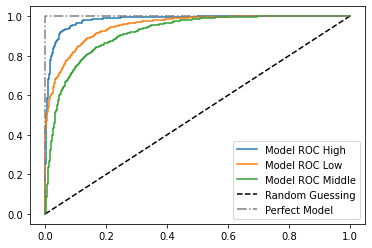

<IPython.core.display.Javascript object>

In [21]:
hi_fpr, hi_tpr, _ = roc_curve(y_test == "High", y_prob_hi)
lo_fpr, lo_tpr, _ = roc_curve(y_test == "Low", y_prob_lo)
mid_fpr, mid_tpr, _ = roc_curve(y_test == "Middle", y_prob_mid)

plt.plot(hi_fpr, hi_tpr, label="Model ROC High")
plt.plot(lo_fpr, lo_tpr, label="Model ROC Low")
plt.plot(mid_fpr, mid_tpr, label="Model ROC Middle")
plt.plot([0, 1], [0, 1], "--", c="black", label="Random Guessing")
plt.plot([0, 0, 1], [0, 1, 1], "-.", c="gray", label="Perfect Model")
plt.legend()
plt.show()